In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
#currently installed theme will be used to
#set plot style if no arguments provided
jtplot.style()

#now load this dataset 
h5f = h5py.File('./datasets/s8_sio2tio2_v2.h5','r')
X = h5f['sizes'][:]
Y = h5f['spectrum'][:]

#create a train - test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
# normalize inputs 
#x_test = (x_test - 50)/20 

print("Dataset has been loaded")

import numpy as np
import mxnet as mx

# Step1: Load the model in MXNet

# Use the same prefix and epoch parameters we used in save_mxnet_model API.
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='./models/my_mod_convprel', epoch=0)

# We use the data_names and data_shapes returned by save_mxnet_model API.
mod = mx.mod.Module(symbol=sym, 
                    data_names=['/first_input6'], 
                    context=mx.gpu(), 
                    label_names=None)
mod.bind(for_training=False, 
         data_shapes=[('/first_input6', (1,8))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)    


#resnet - my_mod_bet   input_21
#fullycon - my_mod_fullycon  first_input2
#conv1d - my_mod_conv1d - first_input4
#convprel - my_mod_convprel - first_input6

Dataset has been loaded


In [ ]:
import time
import de2 as de
import loss_defs as ld

bnds = [(30, 70)]*8
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
lams = np.linspace(300, 1200, 256)
targ_spec = y_test[29]

from sklearn.model_selection import ParameterGrid
param_grid = {
    'psize': [80, 160, 320, 640], 
    'psnew': [10, 20, 40],
    'its_first': [100, 250, 500],
    'its_second': [200, 300, 400],
    'mut': [0.5, 0.75, 0.8, 1.0, 1.2],
    'crossp': [0.3, 0.5, 0.7]
      }
grid = ParameterGrid(param_grid) 



def de_stat(psize,psnew,its_first,its_second,mut,crossp):
    run_time_tot = []
    run_pmre = []
    reps = 5
    targ_spec2 = np.tile(targ_spec, (psize,1))
    for rep in range(reps):
        start = time.time()
        pop, f, b, hstry = de.de_g(
            fobj=ld.mxmod_arr_loss, 
            bounds=bnds, 
            mut=mut,
            crossp=crossp,
            popsize=psize, 
            its=its_first, 
            target=targ_spec2, 
            mxmodel=mod) 
        marg = int(psnew/5)
        pnew1 = pop[np.argsort(f)][:psnew-marg]
        pnew2 = pop[np.argsort(f)][psnew-marg:psnew]
        pnew = np.concatenate((pnew1, pnew2))
        b, c, hstry = de.de_c(
            fobj=ld.loss_func, 
            bounds=bnds, 
            pop=pnew, 
            history=hstry, 
            it_start=its_first, 
            mut=mut,
            crossp=crossp,
            popsize=psnew, 
            its=its_second, 
            target=targ_spec, 
            mats=mats, 
            lams=lams)
        end = time.time()
        run_time_tot.append((end - start)/60.0)
        run_pmre.append(c)
    return  np.mean(run_pmre), np.std(run_pmre), np.mean(run_time_tot)
    
    

pm, pstd, rmd =  de_stat(psize=80,psnew=20,its_first=500,its_second=300,mut=0.8,crossp=0.7)


pm, pstd, rmd



# print(grid)
# for mem in grid:
#     for key in mem:
#         print(key, mem[key])

In [ ]:
import time
import de2 as de
import loss_defs as ld

bnds = [(30, 70)]*8
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
lams = np.linspace(300, 1200, 256)
targ_spec = y_test[29]

psize = 320
targ_spec2 = np.tile(targ_spec, (psize,1))
its_first = 500
psnew = 20
its_second = 300
reps = 100


run_hist = []
run_time1 = []
run_time2 = []
run_time_tot = []
run_pmre = []
run_best = []

for rep in range(reps):
    print("iteration ", rep)
    start = time.time()
    pop, f, b, hstry = de.de_g(fobj=ld.mxmod_arr_loss, bounds=bnds, popsize=psize, its=its_first, target=targ_spec2, mxmodel=mod) 
    #pop, f, b, hstry = de2(fobj=mxmod_arr_loss, bounds=bnds, popsize=psize, its=its_first) 
    end1 = time.time()
    marg = int(psnew/5)
    pnew1 = pop[np.argsort(f)][:psnew-marg]
    pnew2 = pop[np.argsort(f)][psnew-marg:psnew]
    pnew = np.concatenate((pnew1, pnew2))
    #b, c, hstry = de_stage2(fobj=loss_func, bounds=bnds, popint=pnew, history=hstry, itprev=its_first, popsize=psnew, its=its_second)
   # b, c, hstry = de.de_c(fobj=loss_func, bounds=bnds,  popsize=80, its=500)
    b, c, hstry = de.de_c(fobj=ld.loss_func, bounds=bnds, pop=pnew, history=hstry, it_start=its_first, popsize=psnew, its=its_second, target=targ_spec, mats=mats, lams=lams)
    end = time.time()
    run_time1.append((end1 - start)/60.0)
    run_time2.append((end - end1)/60.0)
    run_time_tot.append((end - start)/60.0)
    run_pmre.append(c)
    run_best.append(b)
    run_hist.append(np.asarray(hstry))


iteration  0
0 2.0318959
50 0.6335647
100 0.43585822
150 0.43585822
200 0.4318153
250 0.40194672
300 0.36907107
350 0.36907107
400 0.3634729


In [122]:
pm, pstd, rm, rstd

(0.3027103117249282,
 0.1032019355203007,
 1.8674999300638835,
 0.0020012622708828745)

(array([0.2       , 0.7       , 2.7       , 1.6       , 1.9       ,
        1.2       , 0.5       , 0.5       , 0.1       , 0.03333333,
        0.        ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1. , 2.5, 3. ]),
 <a list of 11 Patch objects>)

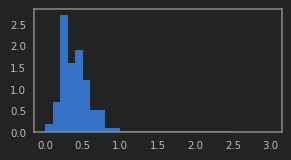

In [88]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme='monokai')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
#jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
#jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
jtplot.style(grid=False, figsize=(4,2), fscale=0.7, s)
# reset default matplotlib rcParams
#jtplot.reset()
plt.s
plt.hist(run_pmre, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 2.5, 3], density=True, stacked=True)

(0.0, 2.1)

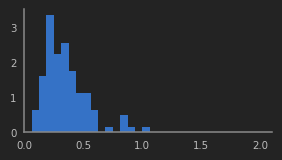

In [110]:
fig, ax = plt.subplots()
ax.hist(run_pmre, bins=np.linspace(0, 2, 33), density=True, stacked=True, histtype='stepfilled')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(left=0.0)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)